In [1]:
!pip install -q xformers
!pip install -q diffusers
!pip install -q kaggle
!pip install -q torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arnaud58/landscape-pictures
!unzip -q landscape-pictures.zip -d landscapes

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0


In [3]:
import os
print("Total images:", len(os.listdir("landscapes")))

Total images: 4319


In [4]:
from PIL import Image

#faced error while importing these files but sorted at the bottom.
input_dir = './landscapes'
output_dir = './landscapes_256'
os.makedirs(output_dir, exist_ok=True)

resized_count = 0
for fname in os.listdir(input_dir):
    try:
        img = Image.open(os.path.join(input_dir, fname)).convert('RGB')
        img = img.resize((256, 256))
        img.save(os.path.join(output_dir, fname))
        resized_count += 1
    except Exception as e:
        continue

print(f"✅ Total resized images: {resized_count}")


✅ Total resized images: 4319


In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets.folder import default_loader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
class LandscapeDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = default_loader(self.image_paths[idx])
        return self.transform(img)

dataset = LandscapeDataset('./landscapes_256', transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)


sample_batch = next(iter(dataloader))
print("Batch shape:", sample_batch.shape)


Batch shape: torch.Size([16, 3, 256, 256])


In [6]:
import torch.nn as nn
from xformers.ops import memory_efficient_attention
#took help of LLM here
class FullAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q.transpose(1, 2)  # (B, N, H, D)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        out = memory_efficient_attention(q, k, v, scale=self.scale)
        out = out.transpose(1, 2).reshape(B, N, C)
        return self.proj(out)

class TinyDiT(nn.Module):
    def __init__(self, dim=512, depth=4, heads=8):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, dim, kernel_size=16, stride=16)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                FullAttention(dim, heads),
                nn.LayerNorm(dim),
                nn.Linear(dim, dim)
            ) for _ in range(depth)
        ])
        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 3 * 16 * 16)
        )


    def forward(self, x):
        x = self.patch_embed(x)  # (B, dim, H/16, W/16)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N, dim)
        for blk in self.blocks:
            x = blk(x) + x
        x = self.head(x)
        x = x.transpose(1, 2).reshape(B, 3, H * 16, W * 16)
        return x


In [7]:
class SlidingWindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.window_size = window_size

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        device = x.device

        # QKV projection and reshape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, H, N, D)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, H, N, D)

        # Transpose for xformers: (B, N, H, D)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Sliding window attention mask: shape (N, N)
        base_mask = torch.full((N, N), float('-inf'), device=device)
        for i in range(N):
            low = max(0, i - self.window_size)
            high = min(N, i + self.window_size + 1)
            base_mask[i, low:high] = 0

        # Expand to shape (B, H, N, N) for xformers
        attn_bias = base_mask.unsqueeze(0).unsqueeze(0).expand(B, self.num_heads, N, N)

        # xformers attention
        out = memory_efficient_attention(q, k, v, attn_bias=attn_bias, scale=self.scale)

        # Reshape back to (B, N, C)
        out = out.transpose(1, 2).reshape(B, N, C)
        return self.proj(out)


In [8]:
class TinyDiT_SWA(nn.Module):
    def __init__(self, dim=512, depth=4, heads=8):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, dim, kernel_size=16, stride=16)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                SlidingWindowAttention(dim, heads),
                nn.LayerNorm(dim),
                nn.Linear(dim, dim)
            ) for _ in range(depth)
        ])
        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 3 * 16 * 16)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        for blk in self.blocks:
            x = blk(x) + x
        x = self.head(x)
        x = x.transpose(1, 2).reshape(B, 3, H * 16, W * 16)
        return x


In [9]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyDiT(dim=512, depth=4, heads=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

os.makedirs("outputs_baseline", exist_ok=True)

for epoch in range(5):  # at first I had kept epochs pretty high but it took a lot of time even with GPU so set it very low.
    total_loss = 0
    model.train()
    for batch in dataloader:
        batch = batch.to(device)
        output = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")


    sample = output[0].detach().cpu().clamp(-1, 1) * 0.5 + 0.5
    transforms.ToPILImage()(sample).save(f"outputs_baseline/sample_epoch{epoch+1}.png")


Epoch 1: Avg Loss = 0.1926
Epoch 2: Avg Loss = 0.1367
Epoch 3: Avg Loss = 0.1210
Epoch 4: Avg Loss = 0.1107
Epoch 5: Avg Loss = 0.1001


In [10]:
model_swa = TinyDiT_SWA(dim=512, depth=4, heads=8).to(device)
optimizer = torch.optim.Adam(model_swa.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

os.makedirs("outputs_swa", exist_ok=True)

for epoch in range(5):
    total_loss = 0
    model_swa.train()
    for batch in dataloader:
        batch = batch.to(device)
        output = model_swa(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"[SWA] Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")

    sample = output[0].detach().cpu().clamp(-1, 1) * 0.5 + 0.5
    transforms.ToPILImage()(sample).save(f"outputs_swa/sample_epoch{epoch+1}.png")


[SWA] Epoch 1: Avg Loss = 0.2074
[SWA] Epoch 2: Avg Loss = 0.1304
[SWA] Epoch 3: Avg Loss = 0.1007
[SWA] Epoch 4: Avg Loss = 0.0896
[SWA] Epoch 5: Avg Loss = 0.0776


Baseline (Full Attention):


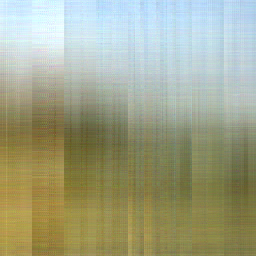

SWA Output:


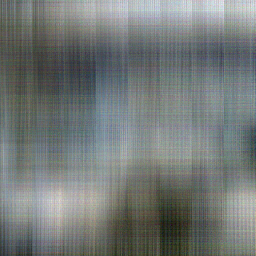

In [14]:
from IPython.display import display
print("Baseline (Full Attention):")
img = Image.open('outputs_baseline/sample_epoch5.png')
display(img)

print("SWA Output:")
img = Image.open('outputs_swa/sample_epoch5.png')
display(img)

In [ ]:
import os
print("Folders in current directory:")
for f in os.listdir():
    if os.path.isdir(f):
        print("📁", f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy folders to your Drive
!cp -r landscapes_256 /content/drive/MyDrive/
!cp -r outputs_baseline /content/drive/MyDrive/
!cp -r outputs_swa /content/drive/MyDrive/


In [ ]:
import os

folders = ["landscapes_256", "outputs_baseline", "outputs_swa"]

for folder in folders:
    if not os.path.exists(folder):
        print(f"❌ Folder '{folder}' NOT found.")
    else:
        files = [f for f in os.listdir(folder) if f.endswith('.png')]
        print(f"📁 {folder}: {len(files)} PNG files")
